In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential

In [7]:
# Load and preprocess the dataset (MNIST in this case)
(x_train, _), (_, _) = mnist.load_data()
x_train = x_train / 255.0  # Normalize pixel values to the range [0, 1]
x_train = np.expand_dims(x_train, axis=-1)  # Add a channel dimension for Conv2D

In [10]:
def build_generator():
    noise_shape = (100,)  # Input noise vector size, 1D vector with 100 elements
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_shape=noise_shape)) # 3D tensor with 256 filters
    model.add(Reshape((7, 7, 256))) # preparing for transpose conv2D, 4D tensor
    model.add(Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='sigmoid')) # For gray scale images 1 filter
    return model #sigmoid pixel intensity


In [12]:
# Define the discriminator model
def build_discriminator():
    input_shape = (28, 28, 1) # 3D tensor, gray sclae image
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=input_shape, activation='relu'))
    model.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [13]:
# Create the generator and discriminator models
generator = build_generator()
discriminator = build_discriminator()

In [14]:
# Compile the discriminator (binary classification)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
# Create a combined model (the GAN)
discriminator.trainable = False  # Freeze the discriminator during GAN training
gan_input = Input(shape=(100,)) # input layer with 100 vectors
x = generator(gan_input) # here it will generate fake data
gan_output = discriminator(x) # pass fake data to descriminator
gan = Model(gan_input, gan_output) #new keras model takes random noise as input and produces descriminator output

In [16]:
# Compile the GAN (binary classification)
gan.compile(loss='binary_crossentropy', optimizer='adam')

In [19]:
# Training parameters
batch_size = 64 # number of data samples used in each iteration of training (can be real or fake)
epochs = 100

2/2 [==============================] - 0s 99ms/step
Epoch 0, D Loss: 0.5542241483926773, G Loss: 4.050620079040527
1/1 [==============================] - 0s 49ms/step


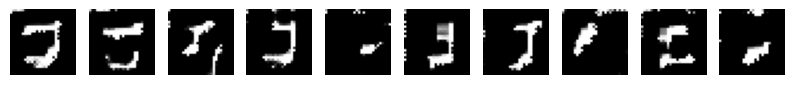

2/2 [==============================] - 0s 101ms/step
Epoch 100, D Loss: 0.5702984929084778, G Loss: 1.7660733461380005
2/2 [==============================] - 0s 96ms/step


2/2 [==============================] - 0s 104ms/step
Epoch 200, D Loss: 0.2709929794073105, G Loss: 2.9070873260498047
2/2 [==============================] - 0s 110ms/step
Epoch 300, D Loss: 0.23310493677854538, G Loss: 2.4541940689086914
2/2 [==============================] - 0s 125ms/step
Epoch 400, D Loss: 0.0559062734246254, G Loss: 4.265210151672363
2/2 [==============================] - 0s 92ms/step


2/2 [==============================] - 0s 98ms/step
Epoch 500, D Loss: 0.011165386065840721, G Loss: 4.5380353927612305
2/2 [==============================] - 0s 105ms/step
Epoch 600, D Loss: 0.023693439550697803, G Loss: 5.012859344482422
2/2 [==============================] - 0s 106ms/step
Epoch 700, D Loss: 0.0024811909534037113, G Loss: 7.422539710998535
2/2 [==============================] - 0s 102ms/step


2/2 [==============================] - 0s 116ms/step
Epoch 800, D Loss: 0.003358556772582233, G Loss: 7.149224281311035
2/2 [==============================] - 0s 114ms/step
Epoch 900, D Loss: 0.01822555554099381, G Loss: 5.979314804077148
2/2 [==============================] - 0s 123ms/step


2/2 [==============================] - 0s 125ms/step


In [20]:
# Training loop
for epoch in range(epochs):
   
    idx = np.random.randint(0, x_train.shape[0], batch_size) # randomly generate the index of real images of batch size
    real_images = x_train[idx] # get the corresponding real images from the training dataset
    fake_images = generator.predict(np.random.normal(0, 1, (batch_size, 100))) # generate the fake images using generator
    
    #these labels are used for computing loss during training of descriminator
    real_labels = np.ones((batch_size, 1)) # create lables for real images as 1
    fake_labels = np.zeros((batch_size, 1)) # create lables for fake images as 0
    
    # train the descriminator on real and fake images and compute loss
    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # average loss is computed
    
    # train the generator model
    noise = np.random.normal(0, 1, (batch_size, 100)) # random noise is a input to the generator
    gan_labels = np.ones((batch_size, 1)) # gan lables are set to 1 indicating that fake images are labeled as real to fool descriminator
    g_loss = gan.train_on_batch(noise, gan_labels) # train generator via GAN and compute loss
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")
    
    if epoch % 100 == 0:
        # Generate and save a sample of generated images
        samples = 10
        noise = np.random.normal(0, 1, (samples, 100))
        generated_images = generator.predict(noise)
        generated_images = generated_images * 0.5 + 0.5  # Rescale images to [0, 1]

        plt.figure(figsize=(10, 1))
        for i in range(samples):        
            plt.subplot(1, samples, i + 1)
            plt.imshow(generated_images[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()
